In [89]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
import seaborn as sns

In [62]:
dataset_path = "/content/drive/MyDrive/Colab Notebooks/bengkod/UASbengkod/ObesityDataSet.csv"
df = pd.read_csv(dataset_path)
df_clean = df.copy()

print("Lima baris pertama:\n", df.head())

Lima baris pertama:
   Age  Gender Height Weight        CALC FAVC FCVC NCP  SCC SMOKE CH2O  \
0  21  Female   1.62     64          no   no    2   3   no    no    2   
1  21  Female   1.52     56   Sometimes   no    3   3  yes   yes    3   
2  23    Male    1.8     77  Frequently   no    2   3   no    no    2   
3  27    Male    1.8     87  Frequently   no    3   3   no    no    2   
4  22    Male   1.78   89.8   Sometimes   no    2   1   no    no    2   

  family_history_with_overweight FAF TUE       CAEC                 MTRANS  \
0                            yes   0   1  Sometimes  Public_Transportation   
1                            yes   3   0  Sometimes  Public_Transportation   
2                            yes   2   1  Sometimes  Public_Transportation   
3                             no   2   0  Sometimes                Walking   
4                             no   0   0  Sometimes  Public_Transportation   

            NObeyesdad  
0        Normal_Weight  
1        Normal_Weigh

In [63]:
print("\nInformasi dataset:")
print(df.info())


Informasi dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2111 entries, 0 to 2110
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   Age                             2097 non-null   object
 1   Gender                          2102 non-null   object
 2   Height                          2099 non-null   object
 3   Weight                          2100 non-null   object
 4   CALC                            2106 non-null   object
 5   FAVC                            2100 non-null   object
 6   FCVC                            2103 non-null   object
 7   NCP                             2099 non-null   object
 8   SCC                             2101 non-null   object
 9   SMOKE                           2106 non-null   object
 10  CH2O                            2105 non-null   object
 11  family_history_with_overweight  2098 non-null   object
 12  FAF                         

In [64]:
print("\nDeskripsi statistik:\n", df.describe())


Deskripsi statistik:
          Age Gender Height Weight       CALC  FAVC  FCVC   NCP   SCC SMOKE  \
count   2097   2102   2099   2100       2106  2100  2103  2099  2101  2106   
unique  1394      3   1562   1518          5     3   808   637     3     3   
top       18   Male    1.7     80  Sometimes   yes     3     3    no    no   
freq     124   1056     58     58       1386  1844   647  1183  1997  2054   

        CH2O family_history_with_overweight   FAF   TUE       CAEC  \
count   2105                           2098  2103  2102       2100   
unique  1263                              3  1186  1130          5   
top        2                            yes     0     0  Sometimes   
freq     441                           1705   404   552       1747   

                       MTRANS      NObeyesdad  
count                    2105            2111  
unique                      6               7  
top     Public_Transportation  Obesity_Type_I  
freq                     1572             3

In [65]:
print("\nMissing values tiap kolom:\n", df.isnull().sum())
print("\nJumlah data duplikat:", df.duplicated().sum())


Missing values tiap kolom:
 Age                               14
Gender                             9
Height                            12
Weight                            11
CALC                               5
FAVC                              11
FCVC                               8
NCP                               12
SCC                               10
SMOKE                              5
CH2O                               6
family_history_with_overweight    13
FAF                                8
TUE                                9
CAEC                              11
MTRANS                             6
NObeyesdad                         0
dtype: int64

Jumlah data duplikat: 18


In [66]:
print("\nJumlah nilai unik tiap kolom:\n", df.nunique())


Jumlah nilai unik tiap kolom:
 Age                               1394
Gender                               3
Height                            1562
Weight                            1518
CALC                                 5
FAVC                                 3
FCVC                               808
NCP                                637
SCC                                  3
SMOKE                                3
CH2O                              1263
family_history_with_overweight       3
FAF                               1186
TUE                               1130
CAEC                                 5
MTRANS                               6
NObeyesdad                           7
dtype: int64


In [67]:
# Cek nilai unik dan missing values
print("Missing Values:")
print(df.isnull().sum())
print("Unique Values:")
print(df.nunique())
print("Checking '?' values:")
print((df == "?").sum())

Missing Values:
Age                               14
Gender                             9
Height                            12
Weight                            11
CALC                               5
FAVC                              11
FCVC                               8
NCP                               12
SCC                               10
SMOKE                              5
CH2O                               6
family_history_with_overweight    13
FAF                                8
TUE                                9
CAEC                              11
MTRANS                             6
NObeyesdad                         0
dtype: int64
Unique Values:
Age                               1394
Gender                               3
Height                            1562
Weight                            1518
CALC                                 5
FAVC                                 3
FCVC                               808
NCP                                637
SCC            

In [68]:
# Define the list of numerical columns
numerical_cols = ['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE']

# Replace '?' with NaN in the entire dataframe
df.replace('?', float('nan'), inplace=True)

# Convert columns to numeric, coercing errors to NaN
df[numerical_cols] = df[numerical_cols].apply(pd.to_numeric, errors='coerce')

# Handle missing values by filling NaNs with the mean of each column (or you can drop rows)
df[numerical_cols] = df[numerical_cols].fillna(df[numerical_cols].mean())

# Now, apply scaling
scaler = StandardScaler()
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])


In [69]:
print("Missing Values:")
print(df.isnull().sum())
print("Unique Values:")
print(df.nunique())
print("Checking '?' values:")
print((df == "?").sum())

Missing Values:
Age                                0
Gender                            22
Height                             0
Weight                             0
CALC                              20
FAVC                              22
FCVC                               0
NCP                                0
SCC                               18
SMOKE                             13
CH2O                               0
family_history_with_overweight    23
FAF                                0
TUE                                0
CAEC                              18
MTRANS                            12
NObeyesdad                         0
dtype: int64
Unique Values:
Age                               1394
Gender                               2
Height                            1562
Weight                            1518
CALC                                 4
FAVC                                 2
FCVC                               808
NCP                                637
SCC            

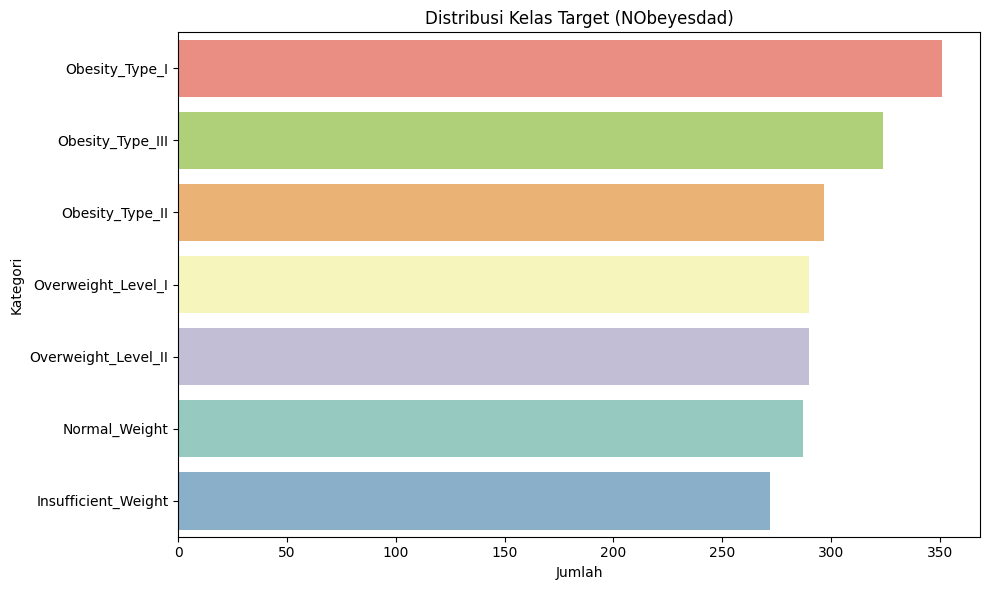

In [70]:
# Visualisasi distribusi kelas target
plt.figure(figsize=(10, 6))
sns.countplot(y='NObeyesdad', data=df, order=df['NObeyesdad'].value_counts().index, palette='Set3', hue='NObeyesdad', legend=False)
plt.title('Distribusi Kelas Target (NObeyesdad)')
plt.xlabel('Jumlah')
plt.ylabel('Kategori')
plt.tight_layout()
plt.show()

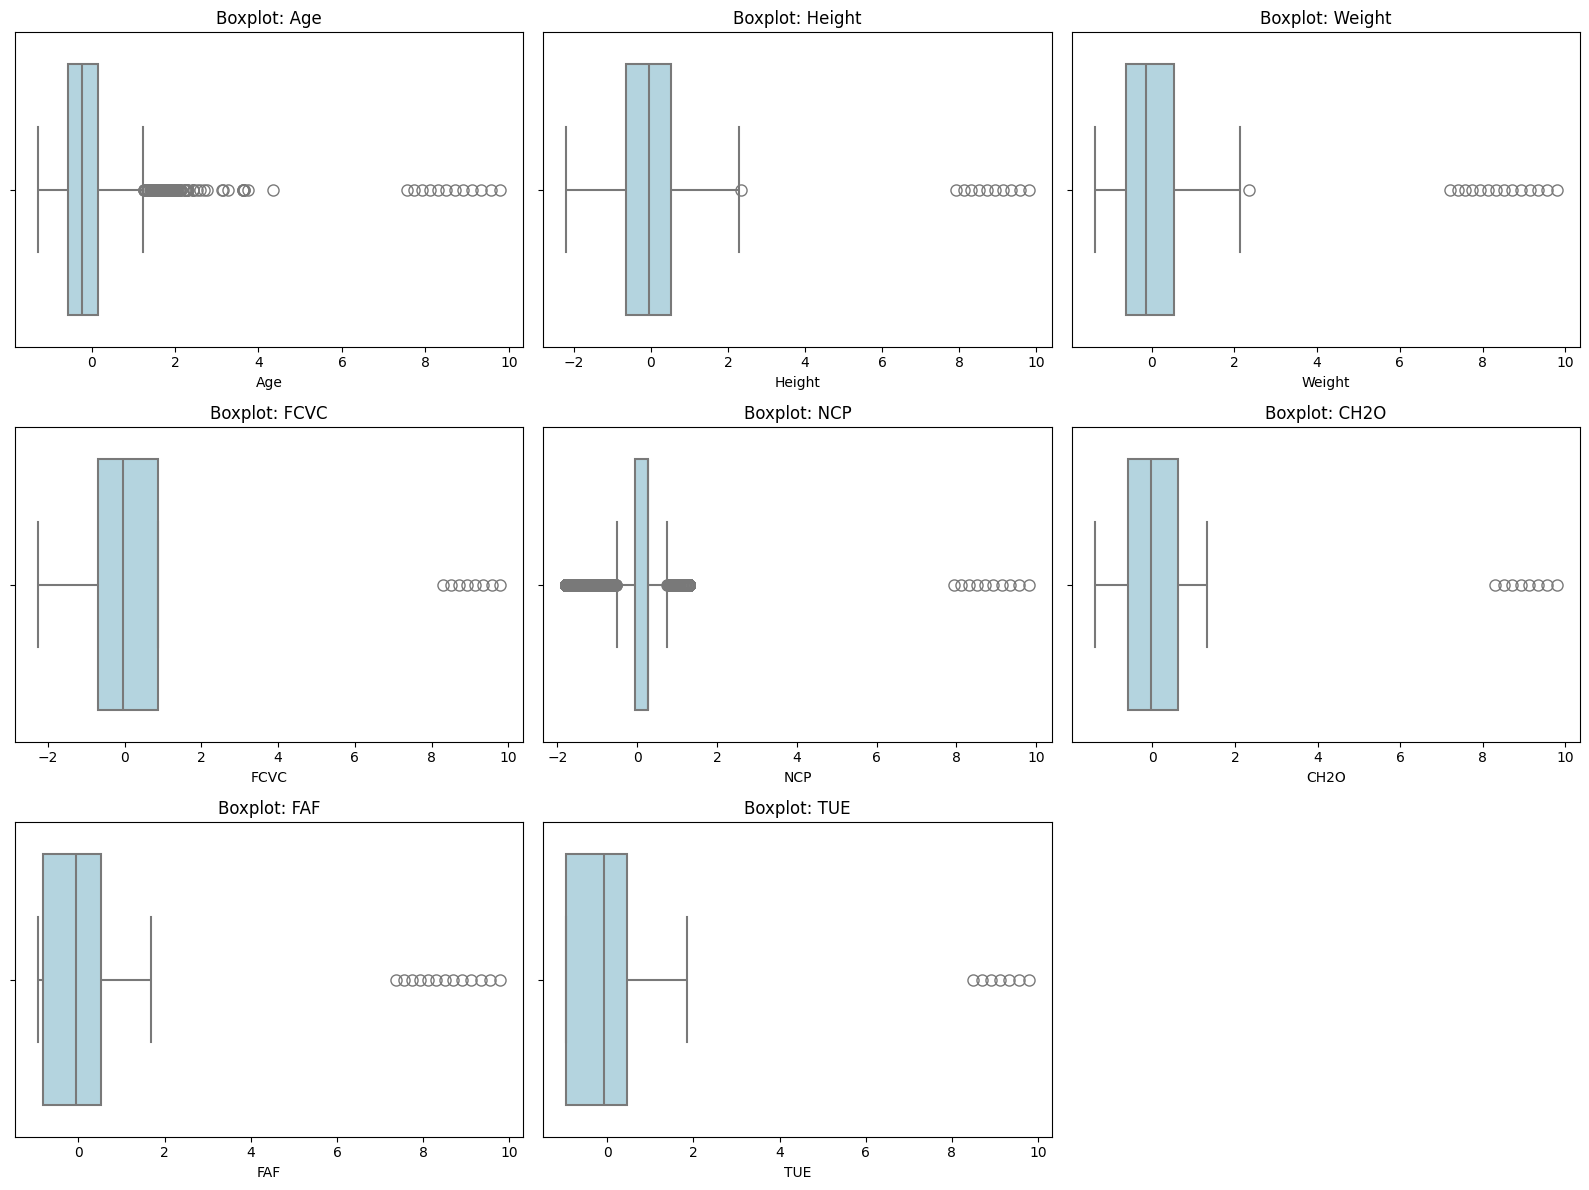

In [71]:
# Visualize Boxplot for Outliers
plt.figure(figsize=(16, 12))
for i, col in enumerate(numerical_cols):
    plt.subplot(3, 3, i+1)  # Arrange boxplots in a 3x3 grid
    sns.boxplot(x=col, data=df, color='lightblue', fliersize=8, linewidth=1.5)  # Increase fliersize for better visibility
    plt.title(f'Boxplot: {col}')
    plt.xlabel(col)

plt.tight_layout()
plt.show()

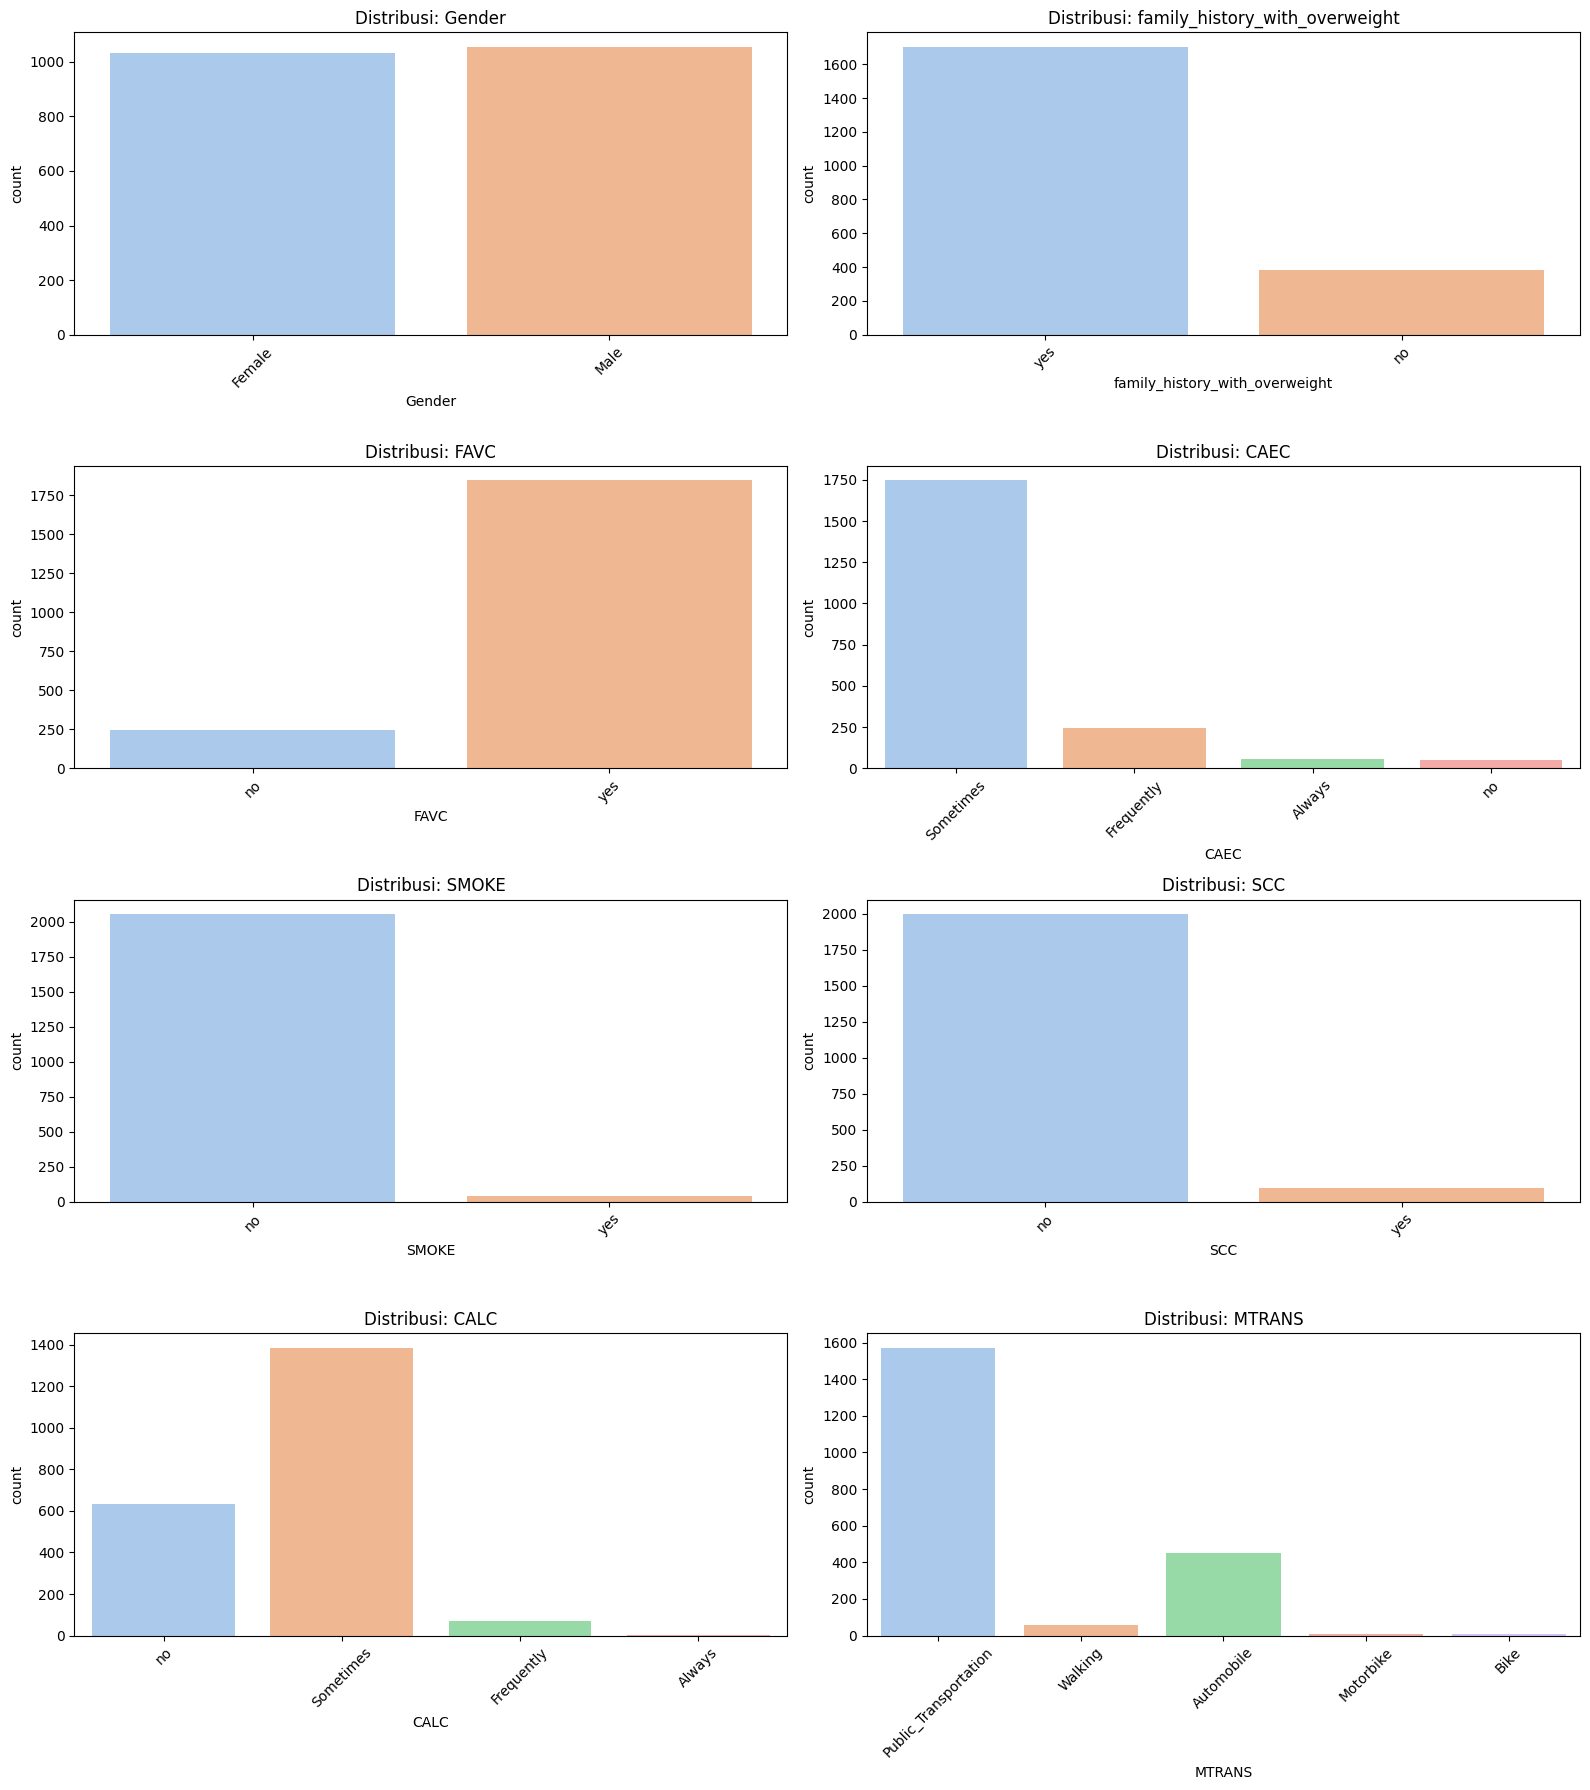

In [72]:
# Visualisasi kolom kategorikal dan biner
categorical_cols = ['Gender', 'family_history_with_overweight', 'FAVC', 'CAEC', 'SMOKE',
                    'SCC', 'CALC', 'MTRANS']

plt.figure(figsize=(16, 18))
for i, col in enumerate(categorical_cols):
    plt.subplot(4, 2, i+1)
    sns.countplot(data=df, x=col, hue=col, palette='pastel', legend=False)
    plt.title(f'Distribusi: {col}')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [73]:
# Gantilah data yang tidak valid (misalnya '?') dengan NaN
df.replace('?', float('nan'), inplace=True)

# Cek data yang tidak valid (contoh: nilai negatif untuk kolom umur atau tinggi badan)
df['Age'] = pd.to_numeric(df['Age'], errors='coerce')
df['Height'] = pd.to_numeric(df['Height'], errors='coerce')

# Cek untuk nilai negatif
invalid_data = df[(df['Age'] < 0) | (df['Height'] < 0)]
print("Data invalid:")
print(invalid_data)


Data invalid:
           Age  Gender    Height    Weight        CALC FAVC      FCVC  \
0    -0.445502  Female -0.740007 -0.683885          no   no -0.693155   
1    -0.445502  Female -1.594294 -0.906212   Sometimes   no  0.869699   
2    -0.205851    Male  0.797709 -0.322602  Frequently   no -0.693155   
4    -0.325676    Male  0.626852  0.033122   Sometimes   no -0.693155   
5     0.513100    Male -0.740007 -0.989585   Sometimes  yes -0.693155   
...        ...     ...       ...       ...         ...  ...       ...   
2106 -0.448277  Female  0.035087  1.189462   Sometimes  yes  0.869699   
2107 -0.327720  Female  0.358469  1.254338   Sometimes  yes  0.869699   
2108 -0.262884  Female  0.389411  1.252848   Sometimes  yes  0.869699   
2109 -0.042657  Female  0.280439  1.243324   Sometimes  yes  0.869699   
2110 -0.126202  Female  0.275193  1.246826   Sometimes  yes  0.869699   

           NCP  SCC SMOKE      CH2O family_history_with_overweight       FAF  \
0     0.277302   no    no -0.

In [74]:
# Cek duplikasi
duplicates = df.duplicated().sum()
print(f"Jumlah data duplikat: {duplicates}")

# Hapus duplikasi jika ada
df.drop_duplicates(inplace=True)

Jumlah data duplikat: 18


In [75]:
# Label Encoding untuk kolom kategorikal
categorical_cols = ['Gender', 'family_history_with_overweight', 'FAVC', 'CAEC', 'SMOKE', 'SCC', 'CALC', 'MTRANS']

label_encoder = LabelEncoder()
for col in categorical_cols:
    df[col] = label_encoder.fit_transform(df[col])

print(df[categorical_cols].head())


   Gender  family_history_with_overweight  FAVC  CAEC  SMOKE  SCC  CALC  \
0       0                               1     0     2      0    0     3   
1       0                               1     0     2      1    1     2   
2       1                               1     0     2      0    0     1   
3       1                               0     0     2      0    0     1   
4       1                               0     0     2      0    0     2   

   MTRANS  
0       3  
1       3  
2       3  
3       4  
4       3  


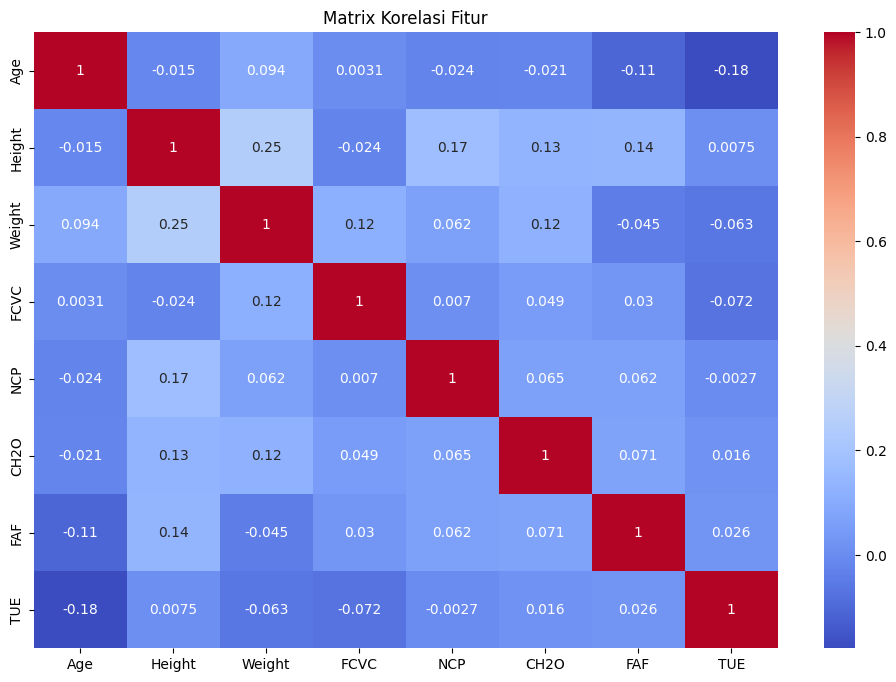

In [76]:
# Compute the correlation matrix
numerical_cols = ['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE'] # Ensure numerical_cols is defined or use the one from previous cells
correlation_matrix = df[numerical_cols].corr()

# Visualize the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Matrix Korelasi Fitur')
plt.show()


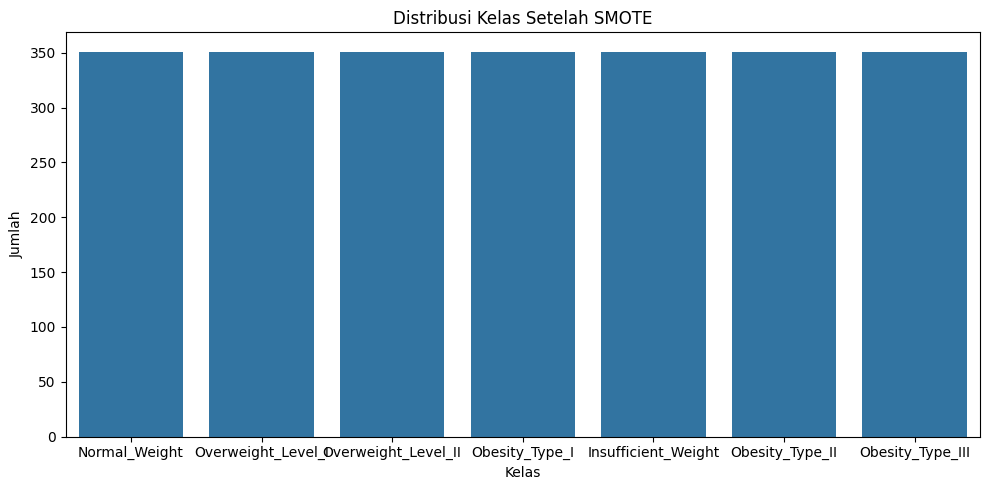

In [77]:
# Pisahkan fitur dan target
X = df.drop(columns=['NObeyesdad'])
y = df['NObeyesdad']

# Terapkan SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Visualisasi distribusi kelas setelah SMOTE
plt.figure(figsize=(10, 5))  # Mengatur ukuran gambar untuk memberi ruang yang cukup
sns.countplot(x=y_resampled)
plt.title('Distribusi Kelas Setelah SMOTE')
plt.xlabel('Kelas')
plt.ylabel('Jumlah')
plt.tight_layout()  # Mengatur layout agar tidak tumpang tindih
plt.show()

In [78]:
# Standarisasi data numerik
scaler = StandardScaler()
X_resampled[numerical_cols] = scaler.fit_transform(X_resampled[numerical_cols])

# Cek data setelah standarisasi
X_resampled[numerical_cols].head()

,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE
0,-0.440435,-0.724813,-0.660956,-0.698841,0.250413,-0.024928,-0.968311,0.446633
1,-0.440435,-1.529751,-0.887237,0.897644,0.250413,1.365424,1.687755,-0.982877
2,-0.199023,0.724075,-0.293249,-0.698841,0.250413,-0.024928,0.802399,0.446633
3,0.283801,0.724075,-0.010398,0.897644,0.250413,-0.024928,0.802399,-0.982877
4,-0.319729,0.563088,0.068800,-0.698841,-1.782955,-0.024928,-0.968311,-0.982877


In [79]:
# Mengecek jumlah missing values per kolom
print(df.isnull().sum())

Age                               0
Gender                            0
Height                            0
Weight                            0
CALC                              0
FAVC                              0
FCVC                              0
NCP                               0
SCC                               0
SMOKE                             0
CH2O                              0
family_history_with_overweight    0
FAF                               0
TUE                               0
CAEC                              0
MTRANS                            0
NObeyesdad                        0
dtype: int64


In [80]:
# Mengecek jumlah duplikasi dalam dataset
print(df.duplicated().sum())

0


In [81]:
# Mengecek jumlah kemunculan '?' pada dataset
print((df == "?").sum())

Age                               0
Gender                            0
Height                            0
Weight                            0
CALC                              0
FAVC                              0
FCVC                              0
NCP                               0
SCC                               0
SMOKE                             0
CH2O                              0
family_history_with_overweight    0
FAF                               0
TUE                               0
CAEC                              0
MTRANS                            0
NObeyesdad                        0
dtype: int64


In [82]:
# Mengecek jumlah nilai unik di setiap kolom
print(df.nunique())

Age                               1394
Gender                               3
Height                            1562
Weight                            1518
CALC                                 5
FAVC                                 3
FCVC                               808
NCP                                637
SCC                                  3
SMOKE                                3
CH2O                              1263
family_history_with_overweight       3
FAF                               1186
TUE                               1130
CAEC                                 5
MTRANS                               6
NObeyesdad                           7
dtype: int64


In [83]:
# Cek nilai unik pada kolom 'Age' dan 'Gender'
print(df['Age'].unique())
print(df['Gender'].unique())

[-0.44550168 -0.20585114  0.27344994 ... -0.26288366 -0.04265679
 -0.12620221]
[0 1 2]


In [84]:
# Ganti nilai yang tidak valid pada kolom 'Age' (misal -1) dengan NaN
df['Age'] = df['Age'].replace(-1, np.nan)

# Mengganti nilai yang tidak valid pada kolom 'Gender' jika ada
df['Gender'] = df['Gender'].replace([3, 4], np.nan)  # Misalnya 3 dan 4 adalah kategori yang tidak valid

# Gantilah dengan imputasi (misal menggunakan median untuk 'Age' atau modus untuk 'Gender')
df['Age'] = df['Age'].fillna(df['Age'].median())
df['Gender'] = df['Gender'].fillna(df['Gender'].mode()[0])


In [85]:
# Ganti nilai yang tidak valid pada kolom 'SMOKE' dan 'MTRANS' dengan NaN jika ada
df['SMOKE'] = df['SMOKE'].replace([3, 4], np.nan)  # Anggap 3 dan 4 adalah nilai yang tidak valid di kolom SMOKE
df['MTRANS'] = df['MTRANS'].replace([6, 7], np.nan)  # Anggap 6 dan 7 adalah nilai yang tidak valid di kolom MTRANS

# Imputasi nilai yang hilang (misalnya menggunakan modus atau nilai yang sering muncul)
df['SMOKE'] = df['SMOKE'].fillna(df['SMOKE'].mode()[0])
df['MTRANS'] = df['MTRANS'].fillna(df['MTRANS'].mode()[0])


In [86]:
# Cek nilai unik setelah pembersihan
print(df['Age'].unique())
print(df['Gender'].unique())


[-0.44550168 -0.20585114  0.27344994 ... -0.26288366 -0.04265679
 -0.12620221]
[0 1 2]


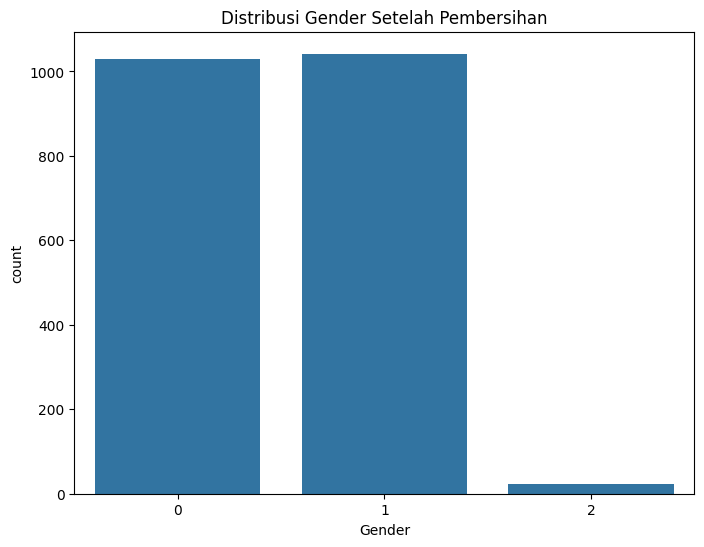

In [87]:
# Visualisasi distribusi nilai unik setelah pembersihan
plt.figure(figsize=(8, 6))
sns.countplot(x='Gender', data=df)
plt.title('Distribusi Gender Setelah Pembersihan')
plt.show()


In [91]:
# Pisah fitur dan target
X = df.drop("NObeyesdad", axis=1)
y = df["NObeyesdad"]

# Normalisasi
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

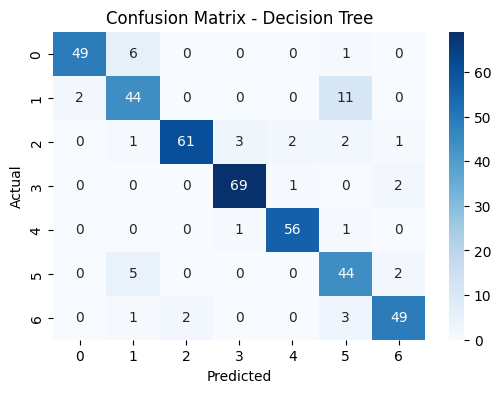

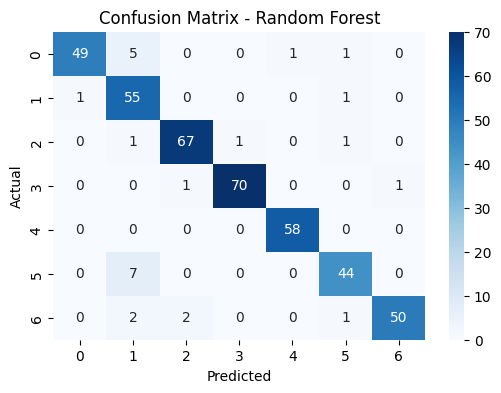

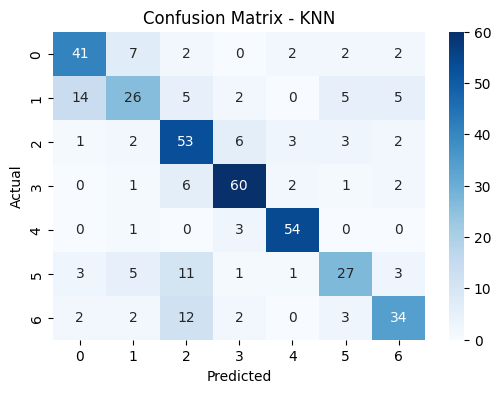

In [102]:
#Pemodelan
models = {
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "KNN": KNeighborsClassifier()
}

results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='weighted')
    rec = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    results.append({
        "Model": name,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1 Score": f1
    })

 # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

<Figure size 1000x600 with 0 Axes>

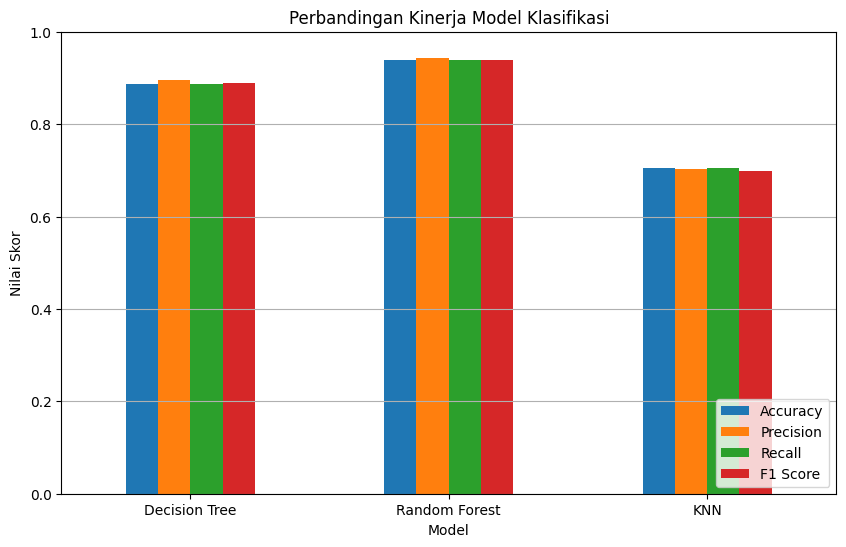

In [100]:
#Visualisasi Perbandingan Hasil
df_result = pd.DataFrame(results)
df_result.set_index("Model", inplace=True)

plt.figure(figsize=(10,6))
df_result.plot(kind='bar', figsize=(10,6))
plt.title("Perbandingan Kinerja Model Klasifikasi")
plt.ylabel("Nilai Skor")
plt.ylim(0, 1)
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.legend(loc='lower right')
plt.show()

In [99]:
#Laporan Lengkap
print("\n--- Laporan Evaluasi Lengkap ---\n")
for name, model in models.items():
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"{name} Classification Report (Akurasi: {acc:.2f}):\n")
    print(classification_report(y_test, y_pred))
    print("="*60)


--- Laporan Evaluasi Lengkap ---

Decision Tree Classification Report (Akurasi: 0.89):

                     precision    recall  f1-score   support

Insufficient_Weight       0.96      0.88      0.92        56
      Normal_Weight       0.77      0.77      0.77        57
     Obesity_Type_I       0.97      0.87      0.92        70
    Obesity_Type_II       0.95      0.96      0.95        72
   Obesity_Type_III       0.95      0.97      0.96        58
 Overweight_Level_I       0.71      0.86      0.78        51
Overweight_Level_II       0.91      0.89      0.90        55

           accuracy                           0.89       419
          macro avg       0.89      0.89      0.88       419
       weighted avg       0.89      0.89      0.89       419

Random Forest Classification Report (Akurasi: 0.94):

                     precision    recall  f1-score   support

Insufficient_Weight       0.98      0.88      0.92        56
      Normal_Weight       0.79      0.96      0.87        57